In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats
import math
import seaborn as sns
import itertools
from transformers import GPT2Tokenizer
import torch
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

def p_ast(pvalue):
    if pvalue <= 0.0001:
        return "****"
    elif pvalue <= 0.001:
        return "***"
    elif pvalue <= 0.01:
        return "**"
    elif pvalue <= 0.05:
        return "*"
    return "ns"

def greater(lis, bench):
    count = 0
    for l in lis:
        if l > bench:
            count += 1
    return count

def get_crit_diff(list1, list2):
    df = len(list1) + len(list2) - 2
    crit_t = stats.t.ppf(0.05, df)
    denom = math.sqrt(((np.std(list1)**2)/len(list1)) + ((np.std(list2)**2)/len(list2)))
    crit_diff = math.sqrt((crit_t * denom)**2)
    return crit_diff

def get_tokenized(prompt):
    tokens=tokenizer.encode(prompt)
    tokenized = [tokenizer.decode(t) for t in tokens]
    return tokenized

def get_token_nums(tokens):
    nums = [tokenizer.encode(t) for t in tokens]
    return nums
    
df = pd.read_csv('./results.csv').dropna()
tokenizer = GPT2Tokenizer.from_pretrained('gpt2-large')

In [ ]:
# Compare gaze durations by news type

eye_df = pd.read_csv('./eyetracking.csv')
violin_df = pd.DataFrame(columns=['dur', 'Veracity'])

for i in range(len(eye_df.index)):
    label = eye_df.loc[i, 'version']
    dur = eye_df.loc[i, 'viewingTimeSec']
    if label == 'true':
        df1 = pd.DataFrame(data={'dur':[float(dur)], 'Veracity': [str('True Stories')]})
        violin_df = pd.concat([violin_df, df1])
    elif label == 'fake':
        df1 = pd.DataFrame(data={'dur':[float(dur)], 'Veracity': [str('Fake Stories')]})
        violin_df = pd.concat([violin_df, df1])
true = violin_df[violin_df['Veracity'] == 'True Stories']['dur'].tolist()
fake = violin_df[violin_df['Veracity'] == 'Fake Stories']['dur'].tolist()

stat, pvalue = stats.ttest_ind(true, fake)

display(violin_df)

fig, ax = plt.subplots(figsize=(8, 5))
ax = sns.violinplot(data=violin_df, order=['True Stories', 'Fake Stories'], inner='quartile')
ax.set_ylabel('Gaze Duration (sec)')
ax.set_title('Gaze Duration by News Type')
ax.text(x = 0.5, y = max([np.mean(true), np.mean(fake)]) + 30, s=p_ast(pvalue), fontsize=15, horizontalalignment='center')
fig.savefig('./figures/fig1.png')
plt.show()

result_df = pd.DataFrame(data={'Veracity':['True', 'Fake'],
                               'N':[len(true), len(fake)],
                               'Avg. Gaze Duration':[np.mean(true), np.mean(fake)],
                               'SD. Gaze Duration':[np.std(true), np.std(fake)],
                               't-stat':[stat, stat],
                               'p-value':[pvalue, pvalue]})
display(result_df)

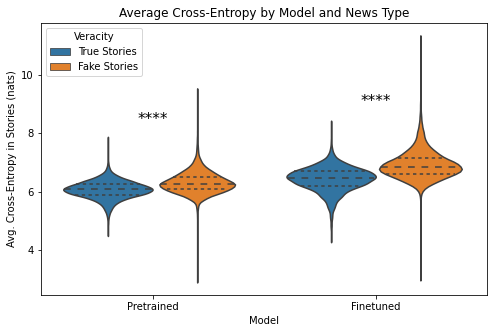

,Model,Veracity,N,Avg. C-E,SD. C-E,Within-model t-stat,Within-model p-value
0,Pretrained,True,6405,6.067344,0.297517,-42.034925,0.0
1,Pretrained,Fake,6405,6.315939,0.368058,NaN,NaN
2,Finetuned,True,6405,6.431275,0.409678,-62.976899,0.0
3,Finetuned,Fake,6405,6.926989,0.478482,NaN,NaN


In [14]:
# Compare average CE in stories

pre_true = [np.mean(list(map(float, j))) for j in [i[1:-1].split(', ') for i in df[df['label'] == 0]['pre_ces']]]
pre_fake = [np.mean(list(map(float, j))) for j in [i[1:-1].split(', ') for i in df[df['label'] == 1]['pre_ces']]]
ft_true = [np.mean(list(map(float, j))) for j in [i[1:-1].split(', ') for i in df[df['label'] == 0]['ft_ces']]]
ft_fake = [np.mean(list(map(float, j))) for j in [i[1:-1].split(', ') for i in df[df['label'] == 1]['ft_ces']]]
pt_mean = np.mean(pre_true)
pf_mean = np.mean(pre_fake)
ft_mean = np.mean(ft_true)
ff_mean = np.mean(ft_fake)
pre_stat, pre_pvalue = stats.ttest_ind(pre_true, pre_fake)
ft_stat, ft_pvalue = stats.ttest_ind(ft_true, ft_fake)

violin_df = pd.DataFrame({'ce':pd.Series(dtype='float'), 'Model':pd.Series(dtype='str'), 'Veracity':pd.Series(dtype='str')})
for i in pre_true:
    df1 = pd.DataFrame(data={'ce':[i], 'Model':['Pretrained'], 'Veracity':['True Stories']})
    violin_df = pd.concat([violin_df, df1])
for i in pre_fake:
    df1 = pd.DataFrame(data={'ce':[i], 'Model':['Pretrained'], 'Veracity':['Fake Stories']})
    violin_df = pd.concat([violin_df, df1])
for i in ft_true:
    df1 = pd.DataFrame(data={'ce':[i], 'Model':['Finetuned'], 'Veracity':['True Stories']})
    violin_df = pd.concat([violin_df, df1])
for i in ft_fake:
    df1 = pd.DataFrame(data={'ce':[i], 'Model':['Finetuned'], 'Veracity':['Fake Stories']})
    violin_df = pd.concat([violin_df, df1])

fig, ax = plt.subplots(figsize=(8, 5))
ax = sns.violinplot(x='Model', y='ce', hue='Veracity', inner='quartile', data=violin_df)
sns.move_legend(ax, 'upper left')
ax.set_ylabel('Avg. Cross-Entropy in Stories (nats)')
ax.set_title('Average Cross-Entropy by Model and News Type')
ax.text(x = 0, y = max([pt_mean, pf_mean]) + 2, s=p_ast(pre_pvalue), fontsize=15, horizontalalignment='center')
ax.text(x = 1, y = max([ft_mean, ff_mean]) + 2, s=p_ast(ft_pvalue), fontsize=15, horizontalalignment='center')
fig.patch.set_facecolor('white')
fig.savefig('./figures/fig2.png')
plt.show()

result_df = pd.DataFrame(data={'Model':['Pretrained', 'Pretrained', 'Finetuned', 'Finetuned'],
                               'Veracity':['True', 'Fake', 'True', 'Fake'],
                               'N':[len(pre_true), len(pre_fake), len(ft_true), len(ft_fake)],
                               'Avg. C-E':[pt_mean, pf_mean, ft_mean, ff_mean],
                               'SD. C-E':[np.std(pre_true), np.std(pre_fake), np.std(ft_true), np.std(ft_fake)],
                               'Within-model t-stat':[pre_stat, np.nan, ft_stat, np.nan],
                               'Within-model p-value':[pre_pvalue, np.nan, ft_pvalue, np.nan]})
display(result_df)

In [ ]:
# Compare average CE in stories

pre_true = [np.std(list(map(float, j))) for j in [i[1:-1].split(', ') for i in df[df['label'] == 0]['pre_ces']]]
pre_fake = [np.std(list(map(float, j))) for j in [i[1:-1].split(', ') for i in df[df['label'] == 1]['pre_ces']]]
ft_true = [np.std(list(map(float, j))) for j in [i[1:-1].split(', ') for i in df[df['label'] == 0]['ft_ces']]]
ft_fake = [np.std(list(map(float, j))) for j in [i[1:-1].split(', ') for i in df[df['label'] == 1]['ft_ces']]]
pt_mean = np.mean(pre_true)
pf_mean = np.mean(pre_fake)
ft_mean = np.mean(ft_true)
ff_mean = np.mean(ft_fake)
pre_stat, pre_pvalue = stats.ttest_ind(pre_true, pre_fake)
ft_stat, ft_pvalue = stats.ttest_ind(ft_true, ft_fake)

violin_df = pd.DataFrame(columns = ['std', 'Model', 'Veracity'])
for i in pre_true:
    df1 = {'std':i, 'Model':'Pretrained', 'Veracity':'True Stories'}
    violin_df = violin_df.append(df1, ignore_index=True)
for i in pre_fake:
    df1 = {'std':i, 'Model':'Pretrained', 'Veracity':'Fake Stories'}
    violin_df = violin_df.append(df1, ignore_index=True)
for i in ft_true:
    df1 = {'std':i, 'Model':'Finetuned', 'Veracity':'True Stories'}
    violin_df = violin_df.append(df1, ignore_index=True)
for i in ft_fake:
    df1 = {'std':i, 'Model':'Finetuned', 'Veracity':'Fake Stories'}
    violin_df = violin_df.append(df1, ignore_index=True)

fig, ax = plt.subplots(figsize=(8, 5))
ax = sns.violinplot(data=violin_df, x='Model', y='std', hue='Veracity', inner='quartile')
sns.move_legend(ax, 'upper right')
ax.set_ylabel('Cross-Entropy StDev. in Stories (nats)')
ax.set_title('Cross-Entropy StDev. by Model and News Type')
ax.text(x = 0, y = max([pt_mean, pf_mean]) + 2, s=p_ast(pre_pvalue), fontsize=15, horizontalalignment='center')
ax.text(x = 1, y = max([ft_mean, ff_mean]) + 2, s=p_ast(ft_pvalue), fontsize=15, horizontalalignment='center')
fig.savefig('./figures/fig5.png')
plt.show()

result_df = pd.DataFrame(data={'Model':['Pretrained', 'Pretrained', 'Finetuned', 'Finetuned'],
                               'Veracity':['True', 'Fake', 'True', 'Fake'],
                               'N':[len(pre_true), len(pre_fake), len(ft_true), len(ft_fake)],
                               'Avg. C-E':[pt_mean, pf_mean, ft_mean, ff_mean],
                               'SD. C-E':[np.std(pre_true), np.std(pre_fake), np.std(ft_true), np.std(ft_fake)],
                               'Within-model t-stat':[pre_stat, np.nan, ft_stat, np.nan],
                               'Within-model p-value':[pre_pvalue, np.nan, ft_pvalue, np.nan]})
display(result_df)

In [ ]:
# Compare maximum cross-entropies in stories

pre_true = [max(list(map(float, j))) for j in [i[1:-1].split(', ') for i in df[df['label'] == 0]['pre_ces']]]
pre_fake = [max(list(map(float, j))) for j in [i[1:-1].split(', ') for i in df[df['label'] == 1]['pre_ces']]]
ft_true = [max(list(map(float, j))) for j in [i[1:-1].split(', ') for i in df[df['label'] == 0]['ft_ces']]]
ft_fake = [max(list(map(float, j))) for j in [i[1:-1].split(', ') for i in df[df['label'] == 1]['ft_ces']]]
pt_mean = np.mean(pre_true)
pf_mean = np.mean(pre_fake)
ft_mean = np.mean(ft_true)
ff_mean = np.mean(ft_fake)
pre_stat, pre_pvalue = stats.ttest_ind(pre_true, pre_fake)
ft_stat, ft_pvalue = stats.ttest_ind(ft_true, ft_fake)

violin_df = pd.DataFrame(columns = ['ce', 'Model', 'Veracity'])
for i in pre_true:
    df1 = {'ce':i, 'Model':'Pretrained', 'Veracity':'True Stories'}
    violin_df = violin_df.append(df1, ignore_index=True)
for i in pre_fake:
    df1 = {'ce':i, 'Model':'Pretrained', 'Veracity':'Fake Stories'}
    violin_df = violin_df.append(df1, ignore_index=True)
for i in ft_true:
    df1 = {'ce':i, 'Model':'Finetuned', 'Veracity':'True Stories'}
    violin_df = violin_df.append(df1, ignore_index=True)
for i in ft_fake:
    df1 = {'ce':i, 'Model':'Finetuned', 'Veracity':'Fake Stories'}
    violin_df = violin_df.append(df1, ignore_index=True)

fig, ax = plt.subplots(figsize=(8, 5))
ax = sns.violinplot(data=violin_df, x='Model', y='ce', hue='Veracity', inner='quartile')
sns.move_legend(ax, 'upper right')
ax.set_ylabel('Max. Cross-Entropy in Stories (nats)')
ax.set_title('Maximum Cross-Entropy by Model and News Type')
ax.text(x = 0, y = max([pt_mean, pf_mean]) + 10, s=p_ast(pre_pvalue), fontsize=15, horizontalalignment='center')
ax.text(x = 1, y = max([ft_mean, ff_mean]) + 10, s=p_ast(ft_pvalue), fontsize=15, horizontalalignment='center')
fig.savefig('./figures/fig3.png')
plt.show()

result_df = pd.DataFrame(data={'Model':['Pretrained', 'Pretrained', 'Finetuned', 'Finetuned'],
                               'Veracity':['True', 'Fake', 'True', 'Fake'],
                               'N':[len(pre_true), len(pre_fake), len(ft_true), len(ft_fake)],
                               'Avg. Max C-E':[pt_mean, pf_mean, ft_mean, ff_mean],
                               'SD. Max C-E':[np.std(pre_true), np.std(pre_fake), np.std(ft_true), np.std(ft_fake)],
                               'Within-model t-stat':[pre_stat, np.nan, ft_stat, np.nan],
                               'Within-model p-value':[pre_pvalue, np.nan, ft_pvalue, np.nan]})
display(result_df)

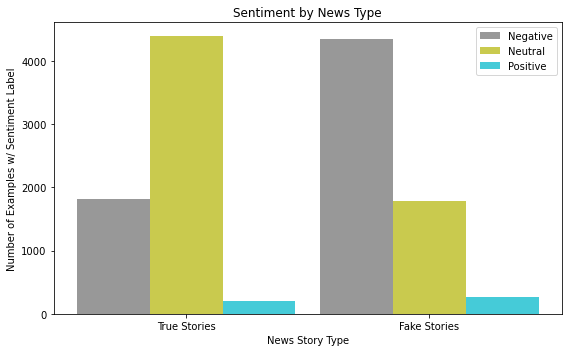

,Veracity,N,Negative,Neutral,Positive,Two-way chi-sq stat,Two-way chi-sq p-value
0,True,6405,1813,4394,198,2159.849862,0.0
1,Fake,6405,4354,1784,267,NaN,NaN


In [15]:
# Compare sentiment distributions

true = df[df['label'] == 0]['sentiment_labels'].value_counts().sort_index()
fake = df[df['label'] == 1]['sentiment_labels'].value_counts().sort_index()
obsv = np.array([true, fake])

chi_stat, chi_p, dof, exp = stats.chi2_contingency(obsv)

x = np.arange(0, 2, 1)
w = 0.3
fig, ax = plt.subplots(figsize=(8, 5))
negative = ax.bar(x - w, height=[true['Negative'], fake['Negative']], width=w, 
                  label='Negative', color='tab:gray', alpha=0.8)
netrual = ax.bar(x, height=[true['Neutral'], fake['Neutral']], width=w, 
                  label='Neutral', color='tab:olive', alpha=0.8)
positive = ax.bar(x + w, height=[true['Positive'], fake['Positive']], width=w, 
                  label='Positive', color='tab:cyan', alpha=0.8)
ax.set_xticks(x, ['True Stories', 'Fake Stories'])
ax.set_xlabel('News Story Type')
ax.set_ylabel('Number of Examples w/ Sentiment Label')
ax.set_title('Sentiment by News Type')
ax.legend()
fig.tight_layout()
fig.patch.set_facecolor('white')
fig.savefig('./figures/fig4.png')
plt.show()

result_df = pd.DataFrame(data={'Veracity':['True', 'Fake'],
                               'N':[sum(true), sum(fake)],
                               'Negative':[true['Negative'], fake['Negative']],
                               'Neutral':[true['Neutral'], fake['Neutral']],
                               'Positive':[true['Positive'], fake['Positive']],
                               'Two-way chi-sq stat':[chi_stat, np.nan],
                               'Two-way chi-sq p-value':[chi_p, np.nan]})
display(result_df)

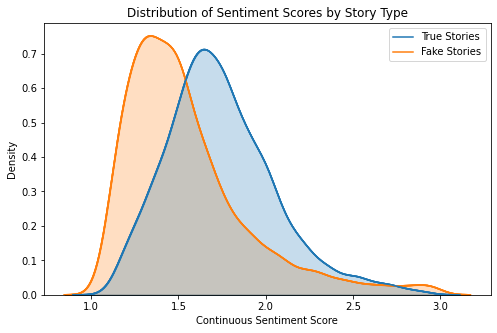

In [16]:
# Distribution of continuous sentiment scores

true = [list(map(float, j)) for j in [i[1:-1].split() for i in df[(df['label'] == 0)]['sentiment_scores']]]
true_cont = [(1*i[0] + 2*i[1] + 3*i[2]) for i in true]

fake = [list(map(float, j)) for j in [i[1:-1].split() for i in df[(df['label'] == 1)]['sentiment_scores']]]
fake_cont = [(1*i[0] + 2*i[1] + 3*i[2]) for i in fake]

d = {'True Stories':true_cont,
     'Fake Stories':fake_cont}

fig, ax = plt.subplots(figsize=(8, 5))
ax = sns.kdeplot(data=d, common_norm=True, fill=True)
ax.set_xlabel('Continuous Sentiment Score')
ax.set_title('Distribution of Sentiment Scores by Story Type')

fake_x = sns.kdeplot(data=d, common_norm=True).lines[0].get_data()[0]
fake_y = sns.kdeplot(data=d, common_norm=True).lines[0].get_data()[1]
true_x = sns.kdeplot(data=d, common_norm=True).lines[1].get_data()[0]
true_y = sns.kdeplot(data=d, common_norm=True).lines[1].get_data()[1]

pd.DataFrame(data={'fake_sent':fake_x, 'fake_prob':fake_y, 'true_sent':true_x, 'true_prob':true_y}).to_csv('./analysis_results/sentiment_dist.csv', index=False)
fig.patch.set_facecolor('white')
fig.savefig('./figures/fig4_1.png')
plt.show()

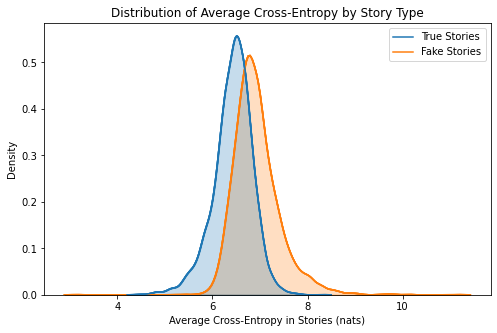

In [4]:
# Distribution of average cross-entropy

true = [np.mean(list(map(float, j))) for j in [i[1:-1].split(', ') for i in df[df['label'] == 0]['ft_ces']]]
fake = [np.mean(list(map(float, j))) for j in [i[1:-1].split(', ') for i in df[df['label'] == 1]['ft_ces']]]

d = {'True Stories':true,
     'Fake Stories':fake}

fig, ax = plt.subplots(figsize=(8, 5))
ax = sns.kdeplot(data=d, common_norm=True, fill=True)
ax.set_xlabel('Average Cross-Entropy in Stories (nats)')
ax.set_title('Distribution of Average Cross-Entropy by Story Type')

fake_x = sns.kdeplot(data=d, common_norm=True).lines[0].get_data()[0]
fake_y = sns.kdeplot(data=d, common_norm=True).lines[0].get_data()[1]
true_x = sns.kdeplot(data=d, common_norm=True).lines[1].get_data()[0]
true_y = sns.kdeplot(data=d, common_norm=True).lines[1].get_data()[1]

pd.DataFrame(data={'fake_ce':fake_x, 'fake_prob':fake_y, 'true_ce':true_x, 'true_prob':true_y}).to_csv('./analysis_results/avg_ce_dist.csv', index=False)
fig.patch.set_facecolor('white')
fig.savefig('./figures/fig2_1.png')
plt.show()

In [ ]:
# Distribution of std in cross-entropy

true = [np.std(list(map(float, j))) for j in [i[1:-1].split(', ') for i in df[df['label'] == 0]['ft_ces']]]
fake = [np.std(list(map(float, j))) for j in [i[1:-1].split(', ') for i in df[df['label'] == 1]['ft_ces']]]

d = {'True Stories':true,
     'Fake Stories':fake}

fig, ax = plt.subplots(figsize=(8, 5))
ax = sns.kdeplot(data=d, common_norm=True, fill=True)
ax.set_xlabel('Average Cross-Entropy in Stories (nats)')
ax.set_title('Distribution of SD in Cross-Entropy by Story Type')

fake_x = sns.kdeplot(data=d, common_norm=True).lines[0].get_data()[0]
fake_y = sns.kdeplot(data=d, common_norm=True).lines[0].get_data()[1]
true_x = sns.kdeplot(data=d, common_norm=True).lines[1].get_data()[0]
true_y = sns.kdeplot(data=d, common_norm=True).lines[1].get_data()[1]

pd.DataFrame(data={'fake_ce':fake_x, 'fake_prob':fake_y, 'true_ce':true_x, 'true_prob':true_y}).to_csv('./analysis_results/std_ce_dist.csv', index=False)
fig.savefig('./figures/fig5_1.png')
plt.show()

In [ ]:
# Distribution of maximum cross entropy

true = [max(list(map(float, j))) for j in [i[1:-1].split(', ') for i in df[df['label'] == 0]['ft_ces']]]
fake = [max(list(map(float, j))) for j in [i[1:-1].split(', ') for i in df[df['label'] == 1]['ft_ces']]]

d = {'True Stories':true,
     'Fake Stories':fake}

fig, ax = plt.subplots(figsize=(8, 5))
ax = sns.kdeplot(data=d, common_norm=True, fill=True)
ax.set_xlabel('Max. Cross-Entropy in Stories (nats)')
ax.set_title('Distribution of Maximum Cross-Entropy by Story Type')

fake_x = sns.kdeplot(data=d, common_norm=True).lines[0].get_data()[0]
fake_y = sns.kdeplot(data=d, common_norm=True).lines[0].get_data()[1]
true_x = sns.kdeplot(data=d, common_norm=True).lines[1].get_data()[0]
true_y = sns.kdeplot(data=d, common_norm=True).lines[1].get_data()[1]

pd.DataFrame(data={'fake_ce':fake_x, 'fake_prob':fake_y, 'true_ce':true_x, 'true_prob':true_y}).to_csv('./analysis_results/max_ce_dist.csv', index=False)
fig.savefig('./figures/fig3_1.png')
plt.show()

In [ ]:
words_df = pd.DataFrame(columns = ['text', 'label', 'pre_max_words', 'ft_max_words'])

for i in range(100):
    label = df.at[i, 'label']
    pre_ces = list(map(float, df.at[i, 'pre_ces'][1:-1].split(', '))) 
    ft_ces = list(map(float, df.at[i, 'ft_ces'][1:-1].split(', ')))
    tokenized = get_tokenized(df.at[i, 'text'])[:1024]
    tokens = get_token_nums(tokenized)
    
    pre_max_idx = np.argmax(pre_ces) + 1
    ft_max_idx = np.argmax(ft_ces) + 1
    
    pre_max_tokens = tokenized[pre_max_idx - 2:(pre_max_idx + 5)]
    ft_max_tokens = tokenized[ft_max_idx - 2:(ft_max_idx + 5)]
    
    pre_max_words = ''.join(pre_max_tokens)
    ft_max_words = ''.join(ft_max_tokens)
    
    df1 = {'text':df.at[i, 'text'], 'label':label, 'pre_max_words':pre_max_words, 'ft_max_words':ft_max_words}
    words_df = words_df.append(df1, ignore_index=True)
    
display(words_df)

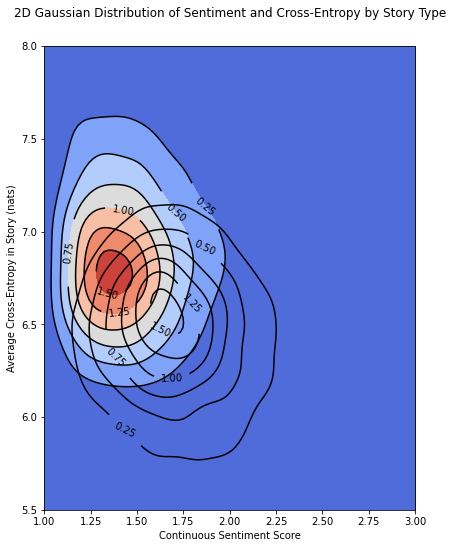

In [3]:
true_sent = [list(map(float, j)) for j in [i[1:-1].split() for i in df[(df['label'] == 0)]['sentiment_scores']]]
true_contsent = [(1*i[0] + 2*i[1] + 3*i[2]) for i in true_sent]

fake_sent = [list(map(float, j)) for j in [i[1:-1].split() for i in df[(df['label'] == 1)]['sentiment_scores']]]
fake_contsent = [(1*i[0] + 2*i[1] + 3*i[2]) for i in fake_sent]

true_ce = [np.mean(list(map(float, j))) for j in [i[1:-1].split(', ') for i in df[df['label'] == 0]['ft_ces']]]
fake_ce = [np.mean(list(map(float, j))) for j in [i[1:-1].split(', ') for i in df[df['label'] == 1]['ft_ces']]]

xmin = 1.0
xmax = 3.0
ymin = 5.5
ymax = 8
xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]

xt = true_contsent
xf = fake_contsent
yt = true_ce
yf = fake_ce
positions = np.vstack([xx.ravel(), yy.ravel()])
values_t = np.vstack([xt, yt])
values_f = np.vstack([xf, yf])
kernel_t = stats.gaussian_kde(values_t)
kernel_f = stats.gaussian_kde(values_f)
f1 = np.reshape(kernel_t(positions).T, xx.shape)
f2 = np.reshape(kernel_f(positions).T, xx.shape)

res_df = pd.DataFrame(columns=['s', 'ce', 'pt', 'pf'])
for i in range(len(xx)):
    for j in range(len(yy)):
        res_df.loc[(i*len(yy)) + j, 's'] = xx[i][j]
        res_df.loc[(i*len(yy)) + j, 'ce'] = yy[i][j]
        res_df.loc[(i*len(yy)) + j, 'pt'] = f1[i][j]
        res_df.loc[(i*len(yy)) + j, 'pf'] = f2[i][j]
res_df.to_csv('./analysis_results/3d.csv', index=False)

fig = plt.figure(constrained_layout=True)
ax = fig.gca()
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)

cfset1 = ax.contourf(xx, yy, f1, cmap='coolwarm')
ax.imshow(np.rot90(f1), cmap='coolwarm')
cset1 = ax.contour(xx, yy, f1, colors='k')
ax.clabel(cset1, inline=1, fontsize=10)

cfset2 = ax.contourf(xx, yy, f2, cmap='coolwarm')
ax.imshow(np.rot90(f2), cmap='coolwarm')
cset2 = ax.contour(xx, yy, f2, colors='k')
ax.clabel(cset2, inline=1, fontsize=10)

fig.set_size_inches(7.5, 7.5)

ax.set_xlabel('Continuous Sentiment Score')
ax.set_ylabel('Average Cross-Entropy in Story (nats)')
ax.set_title('2D Gaussian Distribution of Sentiment and Cross-Entropy by Story Type', y=1.05)

fig.patch.set_facecolor('white')
fig.savefig('./figures/fig6.png')

plt.show()

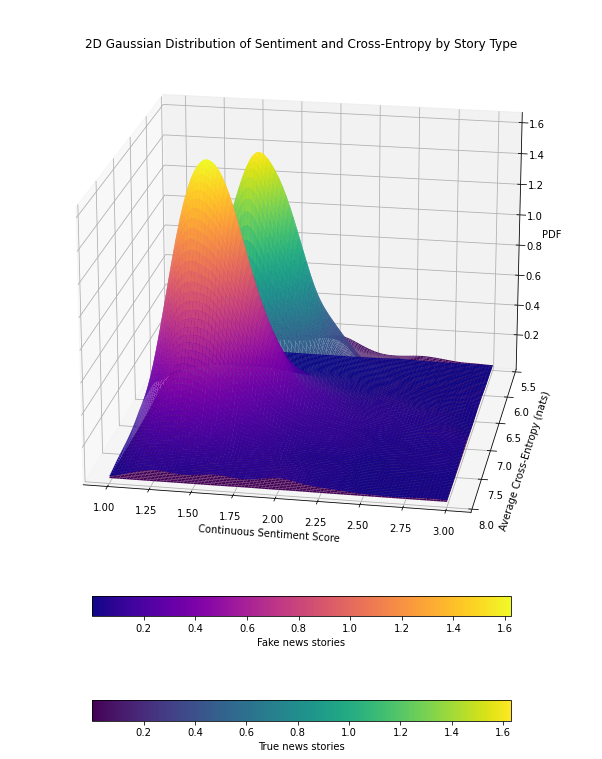

In [4]:
fig = plt.figure(figsize=(15, 15))
ax = plt.axes(projection='3d')

surf1 = ax.plot_surface(xx, yy, f1, rstride=1, cstride=1, cmap='viridis', edgecolor='none')
surf2 = ax.plot_surface(xx, yy, f2, rstride=1, cstride=1, cmap='plasma', edgecolor='none')

ax.set_xlabel('Continuous Sentiment Score')
ax.set_ylabel('Average Cross-Entropy (nats)')
ax.set_zlabel('PDF')
ax.set_title('2D Gaussian Distribution of Sentiment and Cross-Entropy by Story Type', y=1)
fig.colorbar(surf1, shrink=0.5, location='bottom', orientation='horizontal', label='True news stories', pad=0.0005) # add color bar indicating the PDF
fig.colorbar(surf2, shrink=0.5, location='bottom', orientation='horizontal', label='Fake news stories', pad=0.0005) # add color bar indicating the PDF
ax.invert_xaxis()
ax.set_ylim(ymin, ymax)

ax.view_init(20, 100)

fig.patch.set_facecolor('white')
fig.savefig('./figures/fig6_1.png')

plt.show()